# `prachathai-67k` Classification Benchmark

We provide 3 benchmarks for 12-topic multi-label classification of `prachathai-67k`: [fastText](https://github.com/facebookresearch/fastText), LinearSVC and [ULMFit](https://github.com/cstorm125/thai2fit). In all cases, we first finetune the embeddings using all data. The data is then split into train, validation and test sets at 70/10/20 split. The benchmark numbers are based on the test set. Performance metrics are macro-averaged accuracy and F1 score.

| model     | macro-accuracy | macro-F1 |
|-----------|----------------|----------|
| fastText  | 0.9302         | 0.5529   |
| LinearSVC | 0.513277       | 0.552801 |
| **ULMFit**    | **0.948737**       | **0.744875**	 |
| [USE](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3)    | 0.856091    | 0.696172	 |

In [1]:
#colab
!wget https://github.com/PyThaiNLP/prachathai-67k/archive/master.zip; unzip master.zip
!cd prachathai-67k-master; mv * ../
!wget https://www.dropbox.com/s/fsxepdka4l2pr45/prachathai-67k.zip; unzip prachathai-67k.zip
!pip install tensorflow_text
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
!pip install iterative-stratification
!ls

--2020-05-22 15:21:22--  https://github.com/PyThaiNLP/prachathai-67k/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PyThaiNLP/prachathai-67k/zip/master [following]
--2020-05-22 15:21:23--  https://codeload.github.com/PyThaiNLP/prachathai-67k/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [   <=>              ] 659.79K   726KB/s    in 0.9s    

2020-05-22 15:21:24 (726 KB/s) - ‘master.zip’ saved [675630]

Archive:  master.zip
af6ba791cdf4ffcaaa97baaa1daadab5216a73d4
   creating: prachathai-67k-master/
  inflating: prachathai-67k-master/.gitignore  
  inflating:

In [0]:
import pandas as pd
import numpy as np
from pythainlp import word_tokenize
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

benchmark_labels = ['การเมือง','สิทธิมนุษยชน','คุณภาพชีวิต','ต่างประเทศ','สังคม',
                  'สิ่งแวดล้อม','เศรษฐกิจ','วัฒนธรรม','แรงงาน','ความมั่นคง','ไอซีที','การศึกษา']

def replace_newline(t):
    return re.sub('[\n]{1,}', ' ', t)

ft_data = 'ft_data/'

In [3]:
prachathai = pd.read_csv('prachathai-67k.csv')
print(prachathai.shape)
prachathai.head()

(67889, 5)


,url,date,title,body_text,labels
0,https://prachatai.com/print/42,2004-08-24 14:31,"นักวิจัยหนุน ""แม้ว"" เปิด ""จีเอ็มโอ""",ประชาไท --- 23 ส.ค.2547 นักวิจัยฯ ชี้นโยบายจี...,"['ข่าว', 'สิ่งแวดล้อม']"
1,https://prachatai.com/print/41,2004-08-24 14:22,ภาคประชาชนต้านเปิดเสรีจีเอ็มโอ,ประชาไท- 23 ส.ค.2547 นักวิชาการ ภาคประชาชน จ...,"['ข่าว', 'สิ่งแวดล้อม']"
2,https://prachatai.com/print/43,2004-08-24 15:17,จุฬาฯ ห่วงจีเอ็มโอลามข้าวไทย,นโยบายที่อนุญาตให้ปลูกร่วมกับพืชอื่นได้นั้นถื...,"['ข่าว', 'สิ่งแวดล้อม']"
3,https://prachatai.com/print/45,2004-08-24 15:58,ฟองสบู่การเมืองแตก ทักษิณหมดกึ๋น ชนชั้นกลางหมด...,ประชาไท -- 23 ส.ค. 47 ขาประจำทักษิณ ฟันธง ฟอง...,"['ข่าว', 'การเมือง', 'คณะเศรษฐศาสตร์ มหาวิทยาล..."
4,https://prachatai.com/print/47,2004-08-24 16:10,กอต.เสนอเลิกถนนคลองลาน-อุ้มผาง,ประชาไท-23 ส.ค.47 คณะกรรมการอนุรักษ์ ผืนป่าตะ...,"['ข่าว', 'สิ่งแวดล้อม']"


## Train-validation-test Split

We perform 70/10/20 train-validation-test split. The train-validation vs test split is done randomly and the train vs validation split is done using `MultilabelStratifiedShuffleSplit` as implemented by [iterative-stratification](https://github.com/trent-b/iterative-stratification). We will use the test set for classification benchmark.

In [0]:
all_df = prachathai[['body_text', 'labels']].copy()
all_df.head()

#use only benchmark labels
for lab in benchmark_labels:
    all_df[lab] = all_df.labels.map(lambda x: 1 if lab in x else 0)
all_df.drop('labels',axis=1,inplace=True)

In [5]:
all_df.head()

,body_text,การเมือง,สิทธิมนุษยชน,คุณภาพชีวิต,ต่างประเทศ,สังคม,สิ่งแวดล้อม,เศรษฐกิจ,วัฒนธรรม,แรงงาน,ความมั่นคง,ไอซีที,การศึกษา
0,ประชาไท --- 23 ส.ค.2547 นักวิจัยฯ ชี้นโยบายจี...,0,0,0,0,0,1,0,0,0,0,0,0
1,ประชาไท- 23 ส.ค.2547 นักวิชาการ ภาคประชาชน จ...,0,0,0,0,0,1,0,0,0,0,0,0
2,นโยบายที่อนุญาตให้ปลูกร่วมกับพืชอื่นได้นั้นถื...,0,0,0,0,0,1,0,0,0,0,0,0
3,ประชาไท -- 23 ส.ค. 47 ขาประจำทักษิณ ฟันธง ฟอง...,1,0,0,0,0,0,0,0,0,0,0,0
4,ประชาไท-23 ส.ค.47 คณะกรรมการอนุรักษ์ ผืนป่าตะ...,0,0,0,0,0,1,0,0,0,0,0,0


In [6]:
#randomly create test set
idx = np.arange(all_df.shape[0])
np.random.seed(1412)
np.random.shuffle(idx)
train_valid_idx, test_idx = idx[:int(all_df.shape[0] * 0.8)], idx[int(all_df.shape[0] * 0.8):]
print(len(train_valid_idx),len(test_idx))

#save test_df
test_df = all_df.iloc[test_idx,:]
print(test_df.shape)
test_df.to_csv('test_df.csv',index=False)

54311 13578
(13578, 13)


In [7]:
#stratified shuffle split for validation set
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

train_valid_df = all_df.iloc[train_valid_idx,:]
ohe_df = train_valid_df.iloc[:,1:]
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=1412)
train_idx, valid_idx = next(msss.split(ohe_df,ohe_df))
print(len(train_idx),len(valid_idx))

#save train and valid_df
train_df = train_valid_df.iloc[train_idx,:]
print(train_df.shape)
train_df.to_csv('train_df.csv',index=False)

valid_df = all_df.iloc[valid_idx,:]
print(valid_df.shape)
valid_df.to_csv('valid_df.csv',index=False)

47522 6789
(47522, 13)
(6789, 13)


In [0]:
#save train_valid_idx, test_idx for reproducibility
import pickle
pickle.dump(train_valid_idx,open('train_valid_idx.pkl','wb'))
pickle.dump(test_idx,open('test_idx.pkl','wb'))

In [9]:
#test set prevalence
test_df.iloc[:,1:].mean(0)

การเมือง        0.580351
สิทธิมนุษยชน    0.227206
คุณภาพชีวิต     0.167624
ต่างประเทศ      0.124687
สังคม           0.130873
สิ่งแวดล้อม     0.119311
เศรษฐกิจ        0.077036
วัฒนธรรม        0.063632
แรงงาน          0.056857
ความมั่นคง      0.055752
ไอซีที          0.042201
การศึกษา        0.038592
dtype: float64

## [fastText](https://github.com/facebookresearch/fastText) Model

We used embeddings pretrained on [Thai Wikipedia Dump](https://github.com/facebookresearch/fastText/blob/master/docs/pretrained-vectors.md) and finetuned them using all of `prachathai-67k` using skipgram model. After that, we do 12 binary classifications and compute macro-average of performance metrics.

| topic         | prevalence | accuracy | f1     | precision | recall |
|---------------|------------|----------|--------|-----------|--------|
| การเมือง       | 0.5796     | 0.8474   | 0.8731 | 0.8427    | 0.9058 |
| สิทธิมนุษยชน     | 0.2235     | 0.8846   | 0.7018 | 0.8299    | 0.6080 |
| คุณภาพชีวิต      | 0.1693     | 0.8976   | 0.6412 | 0.7887    | 0.5402 |
| ต่างประเทศ     | 0.1233     | 0.9523   | 0.7883 | 0.8713    | 0.7197 |
| สังคม          | 0.1305     | 0.8833   | 0.2933 | 0.7003    | 0.1855 |
| สิ่งแวดล้อม      | 0.1175     | 0.9469   | 0.7330 | 0.8967    | 0.6199 |
| เศรษฐกิจ       | 0.0759     | 0.9394   | 0.4436 | 0.7321    | 0.3182 |
| วัฒนธรรม       | 0.0633     | 0.9473   | 0.3569 | 0.7822    | 0.2312 |
| แรงงาน        | 0.0564     | 0.9726   | 0.7060 | 0.8933    | 0.5836 |
| ความมั่นคง      | 0.0563     | 0.9546   | 0.3990 | 0.7832    | 0.2677 |
| ไอซีที          | 0.0415     | 0.9728   | 0.5745 | 0.8184    | 0.4426 |
| การศึกษา       | 0.0375     | 0.9631   | 0.1237 | 0.5699    | 0.0694 |
| macro_average | 0.1396     | 0.9302   | 0.5529 | 0.7924    | 0.4576 |

In [0]:
train_df = pd.read_csv('train_df.csv')
valid_df = pd.read_csv('valid_df.csv')
test_df = pd.read_csv('test_df.csv')

In [0]:
df_txts = ['train','valid','test']
dfs = [train_df,valid_df,test_df]

for i in range(3):
    df = dfs[i]
    for lab in tqdm_notebook(benchmark_labels):
        ft_lines = []
        for _,row in df.iterrows():
            ft_lab = f'__label__{row[lab]}'
            ft_text = replace_newline(f'{row["body_text"]}')
            ft_line = f'{ft_lab} {ft_text}'
            ft_lines.append(ft_line)

        doc = '\n'.join(ft_lines)
        with open(f'{ft_data}{df_txts[i]}_{lab}.txt','w') as f:
            f.write(doc)
        f.close()

In [0]:
#for fasttext embedding finetuning
ft_lines = []
for _,row in all_df.iterrows():
    ft_lab = '__label__0'
    ft_text = replace_newline(f'{row["body_text"]}')
    ft_line = f'{ft_lab} {ft_text}'
    ft_lines.append(ft_line)

doc = '\n'.join(ft_lines)
with open(f'{ft_data}df_all.txt','w') as f:
    f.write(doc)
f.close()

In [0]:
#finetune with all data
!/home/ubuntu/fastText/fasttext skipgram \
-pretrainedVectors 'model/wiki.th.vec' -dim 300 \
-input ft_data/df_all.txt -output 'model/finetuned'

Read 16M words
Number of words:  161169
Number of labels: 1
Progress: 100.0% words/sec/thread:    8476 lr:  0.000000 loss:  1.250565 ETA:   0h 0m


In [0]:
#train classifier
!/home/ubuntu/fastText/fasttext supervised \
-input 'ft_data/train_การศึกษา.txt' -output 'model/การศึกษา' \
-pretrainedVectors 'model/finetuned.vec' -epoch 5 -dim 300 -wordNgrams 2 

Read 11M words
Number of words:  5773818
Number of labels: 2
Progress: 100.0% words/sec/thread:  276088 lr:  0.000000 loss:  0.027403 ETA:   0h 0m
^C


In [0]:
#get prediction
preds = !/home/ubuntu/fastText/fasttext predict 'model/การศึกษา.bin' 'ft_data/test_การศึกษา.txt'

In [0]:
#calculate score
lab = 'การศึกษา'
pred_num = [int(i[-1]) for i in preds]

from sklearn.metrics import f1_score, precision_score, recall_score
(pred_num == test_df[lab]).mean(), \
f1_score(test_df[lab],pred_num), \
precision_score(test_df[lab],pred_num), \
recall_score(test_df[lab],pred_num)

(0.9631266264054598,
 0.12368728121353562,
 0.5698924731182796,
 0.0693717277486911)

## LinearSVC Model

| target        | prevalence | accuracy | f1       | precision | recall   |
|---------------|------------|----------|----------|-----------|----------|
| การเมือง       | 0.5796     | 0.579663 | 0.000234 | 0.000117  | 1        |
| สิทธิมนุษยชน     | 0.2235     | 0.579663 | 0.733891 | 1         | 0.579643 |
| คุณภาพชีวิต      | 0.1693     | 0.77655  | 0.874223 | 1         | 0.77655  |
| ต่างประเทศ     | 0.1233     | 0.22345  | 0.365278 | 1         | 0.22345  |
| สังคม          | 0.1305     | 0.830657 | 0.907496 | 1         | 0.830657 |
| สิ่งแวดล้อม      | 0.1175     | 0.169343 | 0.289637 | 1         | 0.169343 |
| เศรษฐกิจ       | 0.0759     | 0.876663 | 0.934279 | 1         | 0.876663 |
| วัฒนธรรม       | 0.0633     | 0.123337 | 0.21959  | 1         | 0.123337 |
| แรงงาน        | 0.0564     | 0.869495 | 0.930192 | 1         | 0.869495 |
| ความมั่นคง      | 0.0563     | 0.130505 | 0.230879 | 1         | 0.130505 |
| ไอซีที          | 0.0415     | 0.882457 | 0.937559 | 1         | 0.882457 |
| การศึกษา       | 0.0375     | 0.117543 | 0.21036  | 1         | 0.117543 |
| macro_average | 0.1396     | 0.513277 | 0.552801 | 0.916676  | 0.548304 |

In [0]:
X_train, y_train = train_df['body_text'], train_df.iloc[:,1:]
X_test, y_test = test_df['body_text'], test_df.iloc[:,1:]

In [0]:
import string
import emoji
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    
    #tokenize
    res = [word for word in res.split('|') if word and not re.search(pattern=r"\s+", string=word)]
    
    #post rules
    res = ungroup_emoji(res)
    
    return res

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2))),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=-1)),
])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...ti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=-1))])

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
pred_lab = text_clf.predict(X_test)
pred_ohe = enc.fit_transform(pred_lab).toarray()
y_ohe = enc.fit_transform(test_df.iloc[:,1:]).toarray()

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score
#macro metrics
for i in range(12):
    print(
        (pred_ohe[:,i]==y_ohe[:,i]).mean(),
        f1_score(pred_ohe[:,i],y_ohe[:,i]),
        precision_score(pred_ohe[:,i],y_ohe[:,i]),
        recall_score(pred_ohe[:,i],y_ohe[:,i])
         )

0.5796631806353415 0.00023356300362022654 0.000116795141322121 1.0
0.5796631806353415 0.7338907711914457 1.0 0.5796425414907198
0.7765503019590514 0.8742227012685515 1.0 0.7765503019590514
0.22344969804094858 0.36527811220804235 1.0 0.22344969804094858
0.8306574360485098 0.9074963121898888 1.0 0.8306574360485098
0.16934256395149017 0.28963721867652 1.0 0.16934256395149017
0.8766632297343743 0.9342786876667887 1.0 0.8766632297343743
0.12333677026562577 0.21959001704619957 1.0 0.12333677026562577
0.8694947709530122 0.9301922470847779 1.0 0.8694947709530122
0.13050522904698778 0.2308794788273616 1.0 0.13050522904698778
0.8824569155987627 0.9375586854460094 1.0 0.8824569155987627
0.1175430844012373 0.210359826018189 1.0 0.1175430844012373


## [ULMFit](https://github.com/cstorm125/thai2fit) Model

| target        | prevalence | accuracy | f1       | precision | recall   |
|---------------|------------|----------|----------|-----------|----------|
| การเมือง       | 0.5796     | 0.891295 | 0.906282 | 0.906819  | 0.905745 |
| สิทธิมนุษยชน     | 0.2235     | 0.900083 | 0.774465 | 0.767743  | 0.781306 |
| คุณภาพชีวิต      | 0.1693     | 0.918692 | 0.733848 | 0.661931  | 0.823296 |
| ต่างประเทศ     | 0.1233     | 0.969068 | 0.869132 | 0.832803  | 0.908775 |
| สังคม          | 0.1305     | 0.899592 | 0.497172 | 0.380361  | 0.71753  |
| สิ่งแวดล้อม      | 0.1175     | 0.972505 | 0.884441 | 0.895155  | 0.87398  |
| เศรษฐกิจ       | 0.0759     | 0.95748  | 0.669466 | 0.56727   | 0.816574 |
| วัฒนธรรม       | 0.0633     | 0.962096 | 0.629203 | 0.508146  | 0.825977 |
| แรงงาน        | 0.0564     | 0.9891   | 0.898352 | 0.85453   | 0.946911 |
| ความมั่นคง      | 0.0563     | 0.965434 | 0.655914 | 0.585004  | 0.746385 |
| ไอซีที          | 0.0415     | 0.983503 | 0.787072 | 0.734911  | 0.847203 |
| การศึกษา       | 0.0375     | 0.975991 | 0.633158 | 0.552356  | 0.741652 |
| macro_average | 0.1396     | 0.948737 | 0.744875 | 0.687252  | 0.827945 |

In [0]:
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.text import *
from fastai.callbacks import CSVLogger

from pythainlp.ulmfit import *

model_path = 'prachathai_data/'

train_df = pd.read_csv('train_df.csv')
valid_df = pd.read_csv('valid_df.csv')
test_df = pd.read_csv('test_df.csv')
all_df = pd.concat([train_df,valid_df,test_df],0).reset_index(drop=True)

### Finetune Language Model

See training script `train_lm.py`

In [0]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
# processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
#             NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

# data_lm = (TextList.from_df(all_df, model_path, cols=['body_text'], processor=processor)
#     .random_split_by_pct(valid_pct = 0.01, seed = 1412)
#     .label_for_lm()
#     .databunch(bs=64))
# data_lm.sanity_check()
# data_lm.save('prachathai_lm.pkl')

In [0]:
data_lm = load_data(model_path,'prachathai_lm.pkl')
data_lm.show_batch(5)

idx,text
0,"นักวิจัย จาก กรมวิชาการเกษตร มหาวิทยาลัยเกษตรศาสตร์ และ มหาวิทยาลัยมหิดล เข้าร่วม โดย มี การ นำเสนอ ผลการศึกษา ทดลอง ที่ผ่านมา ซึ่ง พบ ว่า มะละกอ \n จีเอ็มโอ ผ่านการทดสอบ ความปลอดภัย ทาง ชีวภาพ สิ่งแวดล้อม และ อาหาร ระดับ หนึ่ง เท่านั้น \n "" การค้นคว้าวิจัย มะละกอ จีเอ็มโอ รวมถึง พืช ชนิด อื่นๆ ต้อง ทำ ทั้ง ใน โรงเรือน ปิด แปลง ทดลอง รวมทั้ง"
1,การปฏิบัติ ราช การตาม อำนาจหน้าที่ ปกติ และ ตอบ สนองความต้องการ ของ ประชาชน โดย ยึด ประชาชน เป็น ศูนย์กลาง \n รัฐบาล จะ เสริมสร้าง ประสิทธิภาพ ของ ระบบ การ บริหารงาน แบ xxrep 3 ูรณา การ อย่างต่อเนื่อง ไม่ว่า ใน ระดับ จังหวัด หรือ ระดับ อื่นๆ รัฐบาล จะ เน้น ระบบ การบริหารงานบุคคล ภาครัฐ ให้ มี คุณธรรม และ มีประสิทธิภาพ ปรับปรุง ระบบ การบริหาร ทรัพยากรบุคคล จัดระบบ ค่าตอบแทน ให้ เป็นธรรม
2,ปากคำ ของ ชาวบ้าน ทำให้ เรา ทราบ ว่า หมู่บ้าน นี้ ไม่เคย เกิด เหตุร้าย ขึ้น เลย ไม่ว่า สถานการณ์ ใน 3 จังหวัด ชายแดน ภาคใต้ จะ รุนแรง ขนาด ไหน ซึ่ง สาเหตุ หนึ่ง อาจจะ เป็น เพราะ มี หน่วย ทหาร นาวิกโยธิน ปักหลัก อยู่ ใน พื้นที่ นาน นับ สิบ ปี \n \n \n \n
3,ก่อนหน้านี้ ความเสี่ยง จึง ไม่ ต่างกัน \n \n \n \n ทาง ที่ 3 ปฏิวัติ รัฐประหาร เรื่อง นี้ ไม่มี ผู้เชี่ยวชาญ ท่าน ใด กล้า ยืนยัน ว่า จะ ไม่มี แม้ นายทหาร ใหญ่ หลาย คน จะ ออกมา พูด ให้ สบายใจ และ ที่ผ่านมา ก็ แสดงให้เห็น ว่า สงบราบคาบ คามือ ท่าน
4,"เรา ถูก เอารัดเอาเปรียบ จาก ผู้รักษา กฎหมาย มา มาก พอแล้ว "" \n \n \n \n ใน เรื่อง การ ให้ ความช่วยเหลือ ครอบครัว ผู้ ได้รับ ผลกระทบ นั้น นาง อัง ค นา กล่าวว่า "" นาย จาตุรนต์ ฉายแสง รักษาการ รัฐมนตรี ว่าการ กระทรวงศึกษาธิการ และ ประธาน ศูนย์ ให้ ความช่วยเหลือ กรณี คน หาย"


In [0]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06


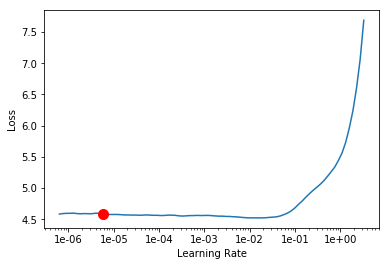

In [0]:
learn.lr_find()
learn.recorder.plot()

### Classification

See training script `train_cls.py`. We could only unfreeze last 3 layers of the model due to insufficient memory.

```
epoch     train_loss  valid_loss
1         0.174497    0.152151
Total time: 51:31
epoch     train_loss  valid_loss
1         0.154524    0.143677
Total time: 53:16
epoch     train_loss  valid_loss
1         0.151477    0.141693
Better model found at epoch 1 with val_loss value: 0.1416931301355362.
2         0.151880    0.141980
3         0.145966    0.137880
Better model found at epoch 3 with val_loss value: 0.13787975907325745.
4         0.132292    0.137459
Better model found at epoch 4 with val_loss value: 0.13745874166488647.
5         0.130727    0.136658
Better model found at epoch 5 with val_loss value: 0.13665838539600372.
6         0.122423    0.136354
Better model found at epoch 6 with val_loss value: 0.13635379076004028.
7         0.109675    0.142987
8         0.094170    0.148554
9         0.087170    0.153496
10        0.082014    0.154279
Total time: 9:39:47
```

### Evaluation

In [0]:
#data
data_cls = load_data(model_path,'prachathai_cls.pkl')
data_cls.sanity_check()

#model
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.5, alpha=2, beta=1, max_len=500)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.load('prachathai_cls');

In [0]:
# probs, y_true = learn.get_preds(ds_type = DatasetType.Test, ordered=True)
# probs = probs.numpy()
# pickle.dump(probs, open(f'{model_path}probs.pkl','wb'))
probs = pickle.load(open(f'{model_path}probs.pkl','rb'))
preds = (probs > 0.5).astype(int)
y_true = np.array(test_df.iloc[:,1:])
probs.shape, y_true.shape

((20367, 12), (20367, 12))

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score
#macro metrics
for i in range(12):
    print(
        (preds[:,i]==y_true[:,i]).mean(),
        f1_score(preds[:,i],y_true[:,i]),
        precision_score(preds[:,i],y_true[:,i]),
        recall_score(preds[:,i],y_true[:,i])
         )

0.8912947414935926 0.9062817473755503 0.9068191444303262 0.9057449868855233
0.9000834683556734 0.7744652554582732 0.7677433531092067 0.7813059033989267
0.9186920017675652 0.733847637415622 0.6619309944911569 0.8232960692390913
0.9690676093680954 0.8691316992106356 0.8328025477707006 0.9087749782797567
0.8995924780281829 0.49717236292107203 0.3803611738148984 0.7175301632363378
0.9725045416605292 0.8844407758976476 0.8951545530492899 0.8739804241435563
0.9574802376393186 0.6694656488549618 0.5672703751617076 0.8165735567970205
0.9620955467177297 0.6292026897214217 0.5081458494957332 0.8259773013871374
0.9891000147297099 0.8983516483516484 0.8545296167247387 0.946911196911197
0.9654342809446654 0.6559139784946237 0.5850043591979076 0.746384872080089
0.9835027249963175 0.7870722433460077 0.7349112426035503 0.8472032742155525
0.9759905729857122 0.6331582895723931 0.5523560209424084 0.7416520210896309


## [Multilingual Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3)

| target        | prevalence | accuracy   |  f1_score  |  precision |  recall    |
|---------------|------------|------------|------------|------------|------------|
|       การเมือง | 0.5796     | 0.73957873 | 0.68247126 | 0.66690067 | 0.69878632 |
| สิทธิมนุษยชน     | 0.2235     | 0.73957873 | 0.77927591 | 0.79213198 | 0.76683047 |
| คุณภาพชีวิต      | 0.1693     | 0.8326705  | 0.89775898 | 0.95063376 | 0.85045613 |
| ต่างประเทศ     | 0.1233     | 0.8326705  | 0.53952169 | 0.43144246 | 0.71984857 |
| สังคม          | 0.1305     | 0.86404478 | 0.92209656 | 0.96664307 | 0.88147491 |
| สิ่งแวดล้อม      | 0.1175     | 0.86404478 | 0.46647399 | 0.35456942 | 0.68158784 |
| เศรษฐกิจ       | 0.0759     | 0.92259537 | 0.95654691 | 0.97332772 | 0.9403349  |
| วัฒนธรรม       | 0.0633     | 0.92259537 | 0.64600876 | 0.56645009 | 0.7515674  |
| แรงงาน        | 0.0564     | 0.87442922 | 0.93239761 | 0.99635624 | 0.87615499 |
| ความมั่นคง      | 0.0563     | 0.87442922 | 0.11886305 | 0.06471581 | 0.7278481  |
| ไอซีที          | 0.0415     | 0.90322581 | 0.946793   | 0.97767185 | 0.91780499 |
| การศึกษา       | 0.0375     | 0.90322581 | 0.46585366 | 0.3537037  | 0.68214286 |
| macro_average | 0.1396     | 0.85609074 | 0.69617178 | 0.67454556 | 0.79123646 |

In [0]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf #tensorflow 2.1.0
import tqdm

enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')

In [11]:
y_train = train_df.iloc[:,1:]
y_test = test_df.iloc[:,1:]
y_train.shape, y_test.shape

((47522, 12), (13578, 12))

In [0]:
X_trains = []
X_tests = []
bs = 10

In [13]:
for i in tqdm.tqdm_notebook(range(y_test.shape[0]//bs+1)):
    X_tests.append(enc(test_df.body_text[(i*bs):((i+1)*bs)]).numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [14]:
for i in tqdm.tqdm_notebook(range(y_train.shape[0]//bs+1)):
    X_trains.append(enc(train_df.body_text[(i*bs):((i+1)*bs)]).numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [0]:
X_test = np.concatenate(X_tests,0)
X_test.shape
pickle.dump(X_test,open('X_test.pkl','wb'))

In [0]:
X_train = np.concatenate(X_trains,0)
X_train.shape
pickle.dump(X_train,open('X_train.pkl','wb'))

In [17]:
X_test.shape,X_train.shape

((13578, 512), (47522, 512))

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

text_clf = Pipeline([
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=-1)),
])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('clf',
                 OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                         class_weight=None,
                                                         dual=True,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         loss='squared_hinge',
                                                         max_iter=1000,
                                                         multi_class='ovr',
                                                         penalty='l2',
                                                         random_state=None,
                                                         tol=0.0001,
                                                         verbose=0),
                                     n_jobs=-1))],
         verbose=False)

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
pred_lab = text_clf.predict(X_test)
pred_ohe = enc.fit_transform(pred_lab).toarray()
y_ohe = enc.fit_transform(test_df.iloc[:,1:]).toarray()

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score
#macro metrics
for i in range(12):
    print(
        (pred_ohe[:,i]==y_ohe[:,i]).mean(),
        f1_score(pred_ohe[:,i],y_ohe[:,i]),
        precision_score(pred_ohe[:,i],y_ohe[:,i]),
        recall_score(pred_ohe[:,i],y_ohe[:,i])
         )

0.7395787302990131 0.6824712643678161 0.6669006669006668 0.6987863184994483
0.7395787302990131 0.7792759051186018 0.7921319796954315 0.7668304668304669
0.832670496391221 0.8977589775897759 0.9506337558372249 0.8504561343678063
0.832670496391221 0.5395216862586137 0.4314424635332253 0.719848566792861
0.8640447783178672 0.9220965563808238 0.9666430720226509 0.8814749072131677
0.8640447783178672 0.4664739884393064 0.3545694200351494 0.6815878378378378
0.9225953748711151 0.9565469053623847 0.9733277240218763 0.9403349048935132
0.9225953748711151 0.646008757157292 0.5664500886001181 0.7515673981191222
0.8744292237442922 0.9323976051702947 0.9963562409965258 0.8761549925484352
0.8744292237442922 0.11886304909560723 0.06471581316826111 0.7278481012658228
0.9032258064516129 0.9467930029154519 0.9776718514801807 0.9178049929345267
0.9032258064516129 0.4658536585365854 0.3537037037037037 0.6821428571428572
